In [1]:
# !pip install pycuda

# Гистограмма

## 1. Классический подход (с чем сравнивать будем)

In [2]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [3]:
im = Image.open("photo.jpg")

In [4]:
w, h = im.size
im = im.resize((w // 4, h // 4))
im = ImageOps.grayscale(im)
im = np.asarray(im).astype(np.float32)
im.shape, im.dtype

((1000, 1500), dtype('float32'))

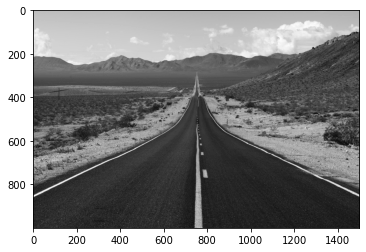

In [5]:
plt.imshow(im, cmap='gray', vmin=0, vmax=255);

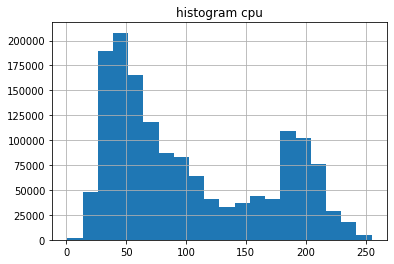

In [6]:
plt.hist(im.reshape(-1), bins=20)
plt.title('histogram cpu')
plt.grid();

## 2. Реализация через cuda

In [7]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [8]:
BIN_COUNT = 20

In [9]:
hist_cpu = np.zeros(BIN_COUNT, dtype=np.int32)
bin_width = np.round(255 / BIN_COUNT, 2)
bin_width

12.75

In [10]:
# копирование исходного изображения
im_gpu = cuda.mem_alloc(im.reshape(-1).nbytes)
cuda.memcpy_htod(im_gpu, im.reshape(-1))
# массив для гистограммы
hist_gpu = cuda.mem_alloc(hist_cpu.nbytes)
cuda.memcpy_htod(hist_gpu, hist_cpu)
# ширина bin
bw_gpu = cuda.mem_alloc(np.array(bin_width, dtype=np.float32).nbytes)
cuda.memcpy_htod(bw_gpu, np.array(bin_width, dtype=np.float32))
# копирование ширины и высоты картинки
w_gpu = cuda.mem_alloc(np.array(im.shape[1]).nbytes)
cuda.memcpy_htod(w_gpu, np.array(im.shape[1]))
h_gpu = cuda.mem_alloc(np.array(im.shape[0]).nbytes)
cuda.memcpy_htod(h_gpu, np.array(im.shape[0]))

In [11]:
mod = SourceModule("""

  __device__ unsigned int getGlobalIdx()
  {
      // глобальный индекс 
      unsigned int innerIdx = threadIdx.x + threadIdx.y * blockDim.x + threadIdx.z * blockDim.x * blockDim.y;
      unsigned int globalIdx = (blockIdx.x + blockIdx.y * gridDim.x + blockIdx.z * gridDim.x * gridDim.y) 
                              * blockDim.x * blockDim.y * blockDim.z 
                              + innerIdx;

      return globalIdx;
  }

  #include <stdio.h>  

  __global__ void Histogram(float * im, int * hist, float * bw, int * w, int * h)
  {
    unsigned int globalIdx = getGlobalIdx();

    if (globalIdx < w[0] * h[0]) {
      int itemBinIdx = (int)(im[globalIdx] / bw[0]);
      atomicAdd(&hist[itemBinIdx], 1);
    }
  }

  """
)

In [12]:
func = mod.get_function("Histogram")

func(
    im_gpu, hist_gpu, bw_gpu, w_gpu, h_gpu,
    block=(16, 16, 1), grid=(128, 128)
)

In [13]:
# копирование на ЦПУ
cuda.memcpy_dtoh(hist_cpu, hist_gpu)


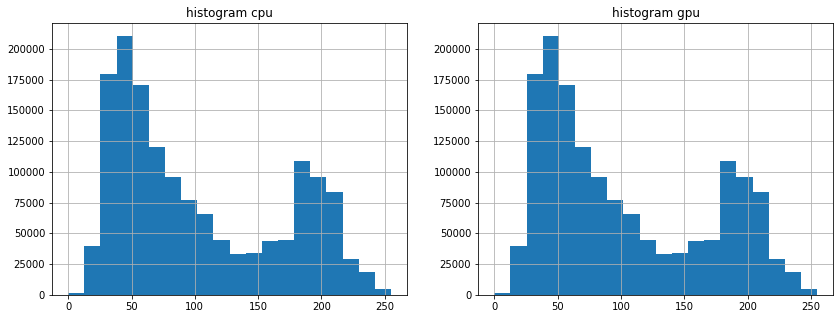

In [14]:
plt.figure(figsize=(14, 5))

plt.subplot("121")
plt.hist(im.reshape(-1), bins=20, range=(0, 255))
plt.title('histogram cpu')
plt.grid()

plt.subplot("122")
plt.bar(np.arange(0, 255, bin_width), hist_cpu, width=bin_width, align='edge')
plt.title('histogram gpu');
plt.grid();